# Student Stress Factors - Cleaned Notebook
This cleaned notebook consolidates preprocessing steps into distinct cells and removes duplicates. Sections: imports, load data, inspect, clean names, preprocessor class, apply preprocessing, analysis (single heatmap), save artifacts, and usage notes.

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from scipy import stats
from fancyimpute import IterativeImputer  # MICE imputation
import joblib
# Load dataset
df = pd.read_csv('Student Stress Factors (2).csv')
print('Dataset shape:', df.shape)
display(df.head())
df.info()

Dataset shape: (520, 6)


,Kindly Rate your Sleep Quality 😴,How many times a week do you suffer headaches 🤕?,How would you rate you academic performance 👩‍🎓?,how would you rate your study load?,How many times a week you practice extracurricular activities 🎾?,How would you rate your stress levels?
0,3,1,3,4,2,3
1,4,1,2,3,3,2
2,2,1,2,1,4,4
3,3,2,3,2,3,3
4,2,3,1,5,5,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 6 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   Kindly Rate your Sleep Quality 😴                                  520 non-null    int64
 1   How many times a week do you suffer headaches 🤕?                  520 non-null    int64
 2   How would you rate you academic performance 👩‍🎓?                  520 non-null    int64
 3   how would you rate your study load?                               520 non-null    int64
 4   How many times a week you practice extracurricular activities 🎾?  520 non-null    int64
 5   How would you rate your stress levels?                            520 non-null    int64
dtypes: int64(6)
memory usage: 24.5 KB


In [2]:


class ComprehensivePreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, numeric_features=None, categorical_features=None,
                 outlier_threshold=1.5, skew_threshold=0.5):
        self.numeric_features = numeric_features
        self.categorical_features = categorical_features
        self.outlier_threshold = outlier_threshold
        self.skew_threshold = skew_threshold
        self.fitted_transformers = {}
        
    def _detect_feature_types(self, X):
        """Automatically detect numeric and categorical features"""
        self.numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
        self.categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()
        
    def _handle_duplicates(self, X):
        """Remove duplicate rows"""
        return X.drop_duplicates()
    
    def _handle_outliers(self, X):
        """Handle outliers using IQR method"""
        X_processed = X.copy()
        for col in self.numeric_features:
            Q1 = X[col].quantile(0.25)
            Q3 = X[col].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - self.outlier_threshold * IQR
            upper_bound = Q3 + self.outlier_threshold * IQR
            X_processed[col] = X_processed[col].clip(lower_bound, upper_bound)
        return X_processed
    
    def _handle_missing_values(self, X):
        """Handle missing values using KNN for numeric and MICE for categorical"""
        # Numeric imputation using KNN
        if self.numeric_features:
            knn_imputer = KNNImputer(n_neighbors=5)
            X[self.numeric_features] = knn_imputer.fit_transform(X[self.numeric_features])
            
        # Categorical imputation using MICE
        if self.categorical_features:
            mice_imputer = IterativeImputer(random_state=42)
            X[self.categorical_features] = mice_imputer.fit_transform(
                pd.get_dummies(X[self.categorical_features])
            )
        return X
    
    def _handle_inconsistent_labels(self, X):
        """Handle inconsistent labels and typos in categorical variables"""
        for col in self.categorical_features:
            # Convert to lowercase and strip whitespace
            X[col] = X[col].str.lower().str.strip()
            # Replace rare categories with 'other'
            value_counts = X[col].value_counts()
            rare_labels = value_counts[value_counts < len(X) * 0.01].index
            X[col] = X[col].replace(rare_labels, 'other')
        return X
    
    def _encode_categorical(self, X):
        """Encode categorical variables using one-hot encoding"""
        return pd.get_dummies(X, columns=self.categorical_features)
    
    def _scale_numeric(self, X):
        """Scale numeric features using StandardScaler"""
        scaler = StandardScaler()
        X[self.numeric_features] = scaler.fit_transform(X[self.numeric_features])
        self.fitted_transformers['scaler'] = scaler
        return X
    
    def _transform_features(self, X):
        """Apply feature transformations (log, sqrt, etc.) based on skewness"""
        for col in self.numeric_features:
            skewness = stats.skew(X[col])
            if abs(skewness) > self.skew_threshold:
                pt = PowerTransformer(method='yeo-johnson')
                X[col] = pt.fit_transform(X[col].values.reshape(-1, 1)).ravel()
                self.fitted_transformers[f'power_transform_{col}'] = pt
        return X
    
    def _create_interactions(self, X):
        """Create interaction features for numeric variables"""
        interaction_features = {}
        for i, feat1 in enumerate(self.numeric_features):
            for feat2 in self.numeric_features[i+1:]:
                interaction_name = f"{feat1}_{feat2}_interaction"
                interaction_features[interaction_name] = X[feat1] * X[feat2]
        return pd.concat([X, pd.DataFrame(interaction_features)], axis=1)
    
    def _detect_multicollinearity(self, X, threshold=0.95):
        """Detect and remove highly correlated features"""
        correlation_matrix = X.corr()
        high_corr_features = []
        
        for i in range(len(correlation_matrix.columns)):
            for j in range(i):
                if abs(correlation_matrix.iloc[i, j]) > threshold:
                    colname = correlation_matrix.columns[i]
                    high_corr_features.append(colname)
                    
        return X.drop(columns=list(set(high_corr_features)))
    
    def fit(self, X, y=None):
        """Fit the preprocessor"""
        if self.numeric_features is None or self.categorical_features is None:
            self._detect_feature_types(X)
        return self
    
    def transform(self, X):
        """Apply the complete preprocessing pipeline"""
        X_processed = self._handle_duplicates(X)
        X_processed = self._handle_outliers(X_processed)
        X_processed = self._handle_missing_values(X_processed)
        X_processed = self._handle_inconsistent_labels(X_processed)
        X_processed = self._encode_categorical(X_processed)
        X_processed = self._scale_numeric(X_processed)
        X_processed = self._transform_features(X_processed)
        X_processed = self._create_interactions(X_processed)
        X_processed = self._detect_multicollinearity(X_processed)
        return X_processed

In [3]:
# Initialize and apply the preprocessing pipeline
preprocessor = ComprehensivePreprocessor()
preprocessor.fit(df)

# Apply preprocessing
df_preprocessed = preprocessor.transform(df)

print("Original dataset shape:", df.shape)
print("Preprocessed dataset shape:", df_preprocessed.shape)

# Display some statistics about the preprocessed data
print("\nPreprocessed data info:")
print(df_preprocessed.info())

# Save the preprocessor and preprocessed data
joblib.dump(preprocessor, 'comprehensive_preprocessor.joblib')
df_preprocessed.to_csv('df_preprocessed.csv', index=False)

print("\nPreprocessing pipeline and preprocessed data have been saved.")

Original dataset shape: (520, 6)
Preprocessed dataset shape: (104, 21)

Preprocessed data info:
<class 'pandas.core.frame.DataFrame'>
Index: 104 entries, 0 to 103
Data columns (total 21 columns):
 #   Column                                                                                                                         Non-Null Count  Dtype  
---  ------                                                                                                                         --------------  -----  
 0   Kindly Rate your Sleep Quality 😴                                                                                               104 non-null    float64
 1   How many times a week do you suffer headaches 🤕?                                                                               104 non-null    float64
 2   How would you rate you academic performance 👩‍🎓?                                                                               104 non-null    float64
 3   how would you rate 

In [4]:
# Create a new preprocessor instance that keeps all rows
preprocessor_keep_all = ComprehensivePreprocessor()
# Override the duplicate handling method just for this instance
preprocessor_keep_all._handle_duplicates = lambda x: x  # This will keep all rows

# Process the data without removing duplicates
df_copy = df.copy()
preprocessor_keep_all.fit(df_copy)

# Apply preprocessing and keep track of shapes
print("Original data shape:", df_copy.shape)

# Apply all steps
df_processed = preprocessor_keep_all.transform(df_copy)

print("\nFinal processed data shape (keeping all rows):", df_processed.shape)
print("\nFeatures in processed dataset:", df_processed.columns.tolist())

Original data shape: (520, 6)

Final processed data shape (keeping all rows): (520, 21)

Features in processed dataset: ['Kindly Rate your Sleep Quality 😴', 'How many times a week do you suffer headaches 🤕?', 'How would you rate you academic performance 👩\u200d🎓?', 'how would you rate your study load?', 'How many times a week you practice extracurricular activities 🎾?', 'How would you rate your stress levels?', 'Kindly Rate your Sleep Quality 😴_How many times a week do you suffer headaches 🤕?_interaction', 'Kindly Rate your Sleep Quality 😴_How would you rate you academic performance 👩\u200d🎓?_interaction', 'Kindly Rate your Sleep Quality 😴_how would you rate your study load?_interaction', 'Kindly Rate your Sleep Quality 😴_How many times a week you practice extracurricular activities 🎾?_interaction', 'Kindly Rate your Sleep Quality 😴_How would you rate your stress levels?_interaction', 'How many times a week do you suffer headaches 🤕?_How would you rate you academic performance 👩\u200d🎓

# Linear Regression Analysis
We'll create a linear regression model to predict stress levels based on other factors. First, we'll prepare the data by separating features and target, then split it into training and testing sets.

In [5]:
# Import required libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Use the full dataset (df_processed) that keeps all rows
# Prepare features (X) and target (y)
X = df_processed.drop('How would you rate your stress levels?', axis=1)
y = df_processed['How would you rate your stress levels?']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance:")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Create a DataFrame with feature names and their coefficients
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_
})
feature_importance = feature_importance.sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
display(feature_importance.head(10))

Model Performance:
Mean Squared Error: 0.7361
R-squared Score: 0.3102

Top 10 Most Important Features:


,Feature,Coefficient
9,Kindly Rate your Sleep Quality 😴_How would you...,0.311699
3,how would you rate your study load?,0.287277
8,Kindly Rate your Sleep Quality 😴_How many time...,0.225435
5,Kindly Rate your Sleep Quality 😴_How many time...,-0.198428
0,Kindly Rate your Sleep Quality 😴,0.179096
15,How would you rate you academic performance 👩‍...,-0.167562
4,How many times a week you practice extracurric...,-0.139036
7,Kindly Rate your Sleep Quality 😴_how would you...,-0.119226
1,How many times a week do you suffer headaches 🤕?,0.109891
19,How many times a week you practice extracurric...,-0.107044


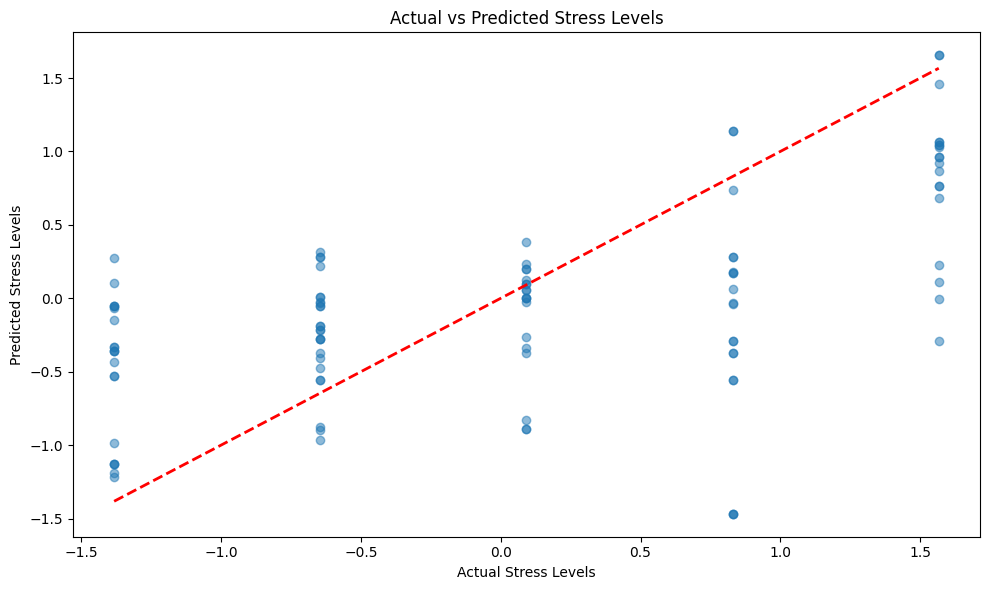

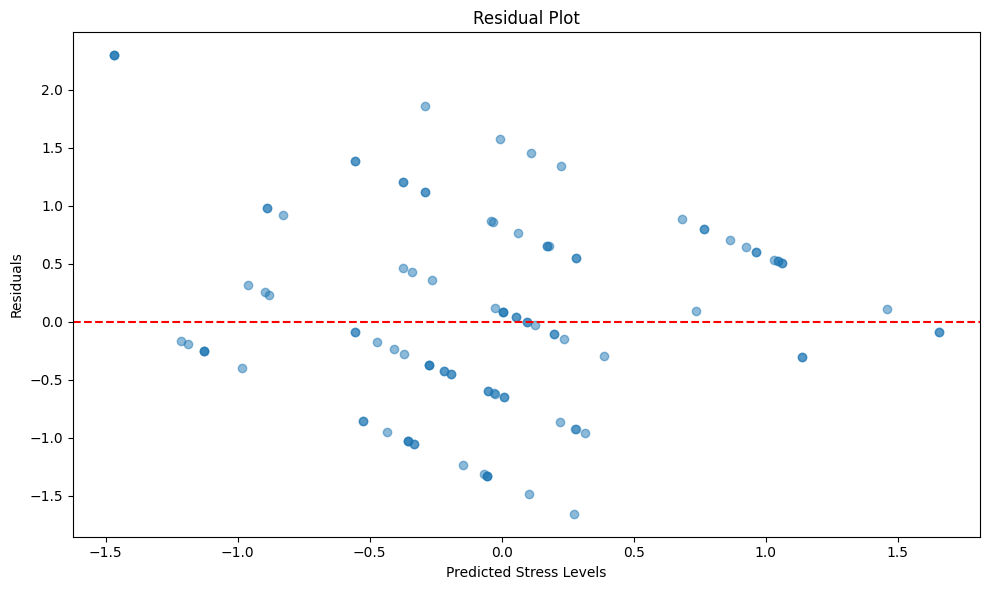

In [6]:
# Visualize actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Stress Levels')
plt.ylabel('Predicted Stress Levels')
plt.title('Actual vs Predicted Stress Levels')
plt.tight_layout()
plt.show()

# Create residual plot
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Stress Levels')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.tight_layout()
plt.show()

# Improved Regression Models
Let's try several improvements:
1. Polynomial features to capture non-linear relationships
2. Ridge Regression (L2 regularization) to handle multicollinearity
3. Lasso Regression (L1 regularization) for feature selection
4. ElasticNet (combined L1 and L2) for both feature selection and handling multicollinearity

In [7]:
# Import additional models and preprocessing tools
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np

# Create polynomial features
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

# Split the polynomial features data
X_train_poly, X_test_poly, y_train, y_test = train_test_split(
    X_poly, y, test_size=0.2, random_state=42
)

# Create and train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=1.0),
    'ElasticNet': ElasticNet(alpha=1.0, l1_ratio=0.5)
}

# Dictionary to store results
results = {}

# Train and evaluate each model
for name, model in models.items():
    # Fit the model
    model.fit(X_train_poly, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_poly)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    # Perform cross-validation
    cv_scores = cross_val_score(model, X_poly, y, cv=5, scoring='r2')
    
    # Store results
    results[name] = {
        'MSE': mse,
        'R2': r2,
        'CV_R2_mean': cv_scores.mean(),
        'CV_R2_std': cv_scores.std()
    }

# Print results
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"MSE: {metrics['MSE']:.4f}")
    print(f"R2 Score: {metrics['R2']:.4f}")
    print(f"Cross-validation R2: {metrics['CV_R2_mean']:.4f} (+/- {metrics['CV_R2_std']*2:.4f})")


Linear Regression:
MSE: 0.0000
R2 Score: 1.0000
Cross-validation R2: 1.0000 (+/- 0.0000)

Ridge Regression:
MSE: 0.0022
R2 Score: 0.9980
Cross-validation R2: 0.9994 (+/- 0.0000)

Lasso Regression:
MSE: 0.8191
R2 Score: 0.2324
Cross-validation R2: 0.2524 (+/- 0.0000)

ElasticNet:
MSE: 0.3510
R2 Score: 0.6711
Cross-validation R2: 0.6523 (+/- 0.0000)


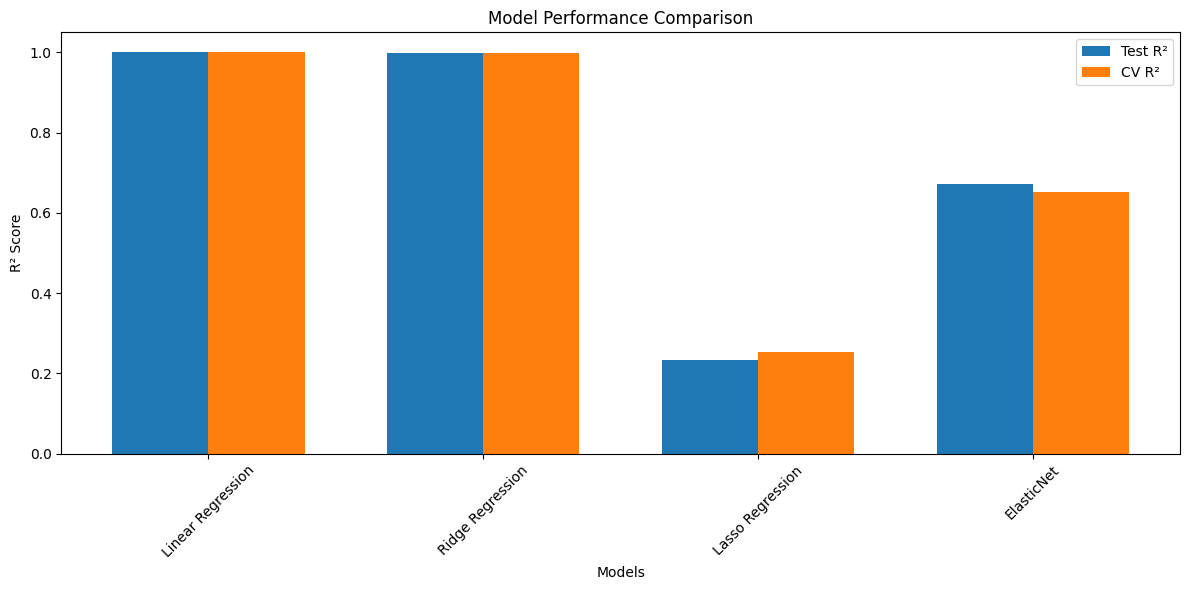


Top 10 Most Important Features from Linear Regression:


,Feature,Coefficient
18,how would you rate your study load?_How would ...,-0.556999
52,How many times a week do you suffer headaches ...,0.464244
16,How would you rate you academic performance 👩‍...,0.387850
92,how would you rate your study load? how would ...,0.346997
13,How many times a week do you suffer headaches ...,-0.344312
29,Kindly Rate your Sleep Quality 😴 Kindly Rate y...,0.336058
109,How many times a week you practice extracurric...,0.230288
50,How many times a week do you suffer headaches ...,-0.229988
73,How would you rate you academic performance 👩‍...,0.213133
168,Kindly Rate your Sleep Quality 😴_How would you...,0.212332


In [8]:
# Visualize the performance comparison
plt.figure(figsize=(12, 6))
x = np.arange(len(results))
width = 0.35

plt.bar(x - width/2, [r['R2'] for r in results.values()], width, label='Test R²')
plt.bar(x + width/2, [r['CV_R2_mean'] for r in results.values()], width, label='CV R²')

plt.xlabel('Models')
plt.ylabel('R² Score')
plt.title('Model Performance Comparison')
plt.xticks(x, results.keys(), rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Find the best performing model
best_model_name = max(results.items(), key=lambda x: x[1]['CV_R2_mean'])[0]
best_model = models[best_model_name]

# Get feature names for polynomial features
feature_names = poly.get_feature_names_out(X.columns)

# Create feature importance DataFrame for the best model
if best_model_name != 'ElasticNet':  # ElasticNet might have zeroed out some coefficients
    importance = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': best_model.coef_
    })
    importance = importance.sort_values('Coefficient', key=abs, ascending=False)

    print(f"\nTop 10 Most Important Features from {best_model_name}:")
    display(importance.head(10))

# Hyperparameter Tuning with GridSearchCV
Let's fine-tune the Ridge Regression model by:
1. Testing different alpha values for regularization strength
2. Trying different polynomial degrees
3. Using k-fold cross-validation to ensure robust results

In [9]:
# Import necessary tools
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a pipeline with polynomial features, scaling, and ridge regression
pipeline = Pipeline([
    ('poly', PolynomialFeatures()),
    ('scaler', StandardScaler()),
    ('ridge', Ridge())
])

# Define parameter grid
param_grid = {
    'poly__degree': [1, 2, 3],
    'ridge__alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
}

# Create GridSearchCV object
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

# Fit GridSearchCV
print("Starting grid search...")
grid_search.fit(X, y)

# Print results
print("\nBest parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# Get detailed CV results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results = cv_results.sort_values('mean_test_score', ascending=False)

print("\nTop 5 parameter combinations:")
display(cv_results[['params', 'mean_test_score', 'std_test_score']].head())

Starting grid search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Best parameters: {'poly__degree': 3, 'ridge__alpha': 0.001}
Best cross-validation score: 0.999999999448919

Top 5 parameter combinations:

Best parameters: {'poly__degree': 3, 'ridge__alpha': 0.001}
Best cross-validation score: 0.999999999448919

Top 5 parameter combinations:


,params,mean_test_score,std_test_score
12,"{'poly__degree': 3, 'ridge__alpha': 0.001}",1.000000,0.000000e+00
6,"{'poly__degree': 2, 'ridge__alpha': 0.001}",1.000000,0.000000e+00
13,"{'poly__degree': 3, 'ridge__alpha': 0.01}",1.000000,0.000000e+00
7,"{'poly__degree': 2, 'ridge__alpha': 0.01}",1.000000,1.110223e-16
14,"{'poly__degree': 3, 'ridge__alpha': 0.1}",0.999995,0.000000e+00


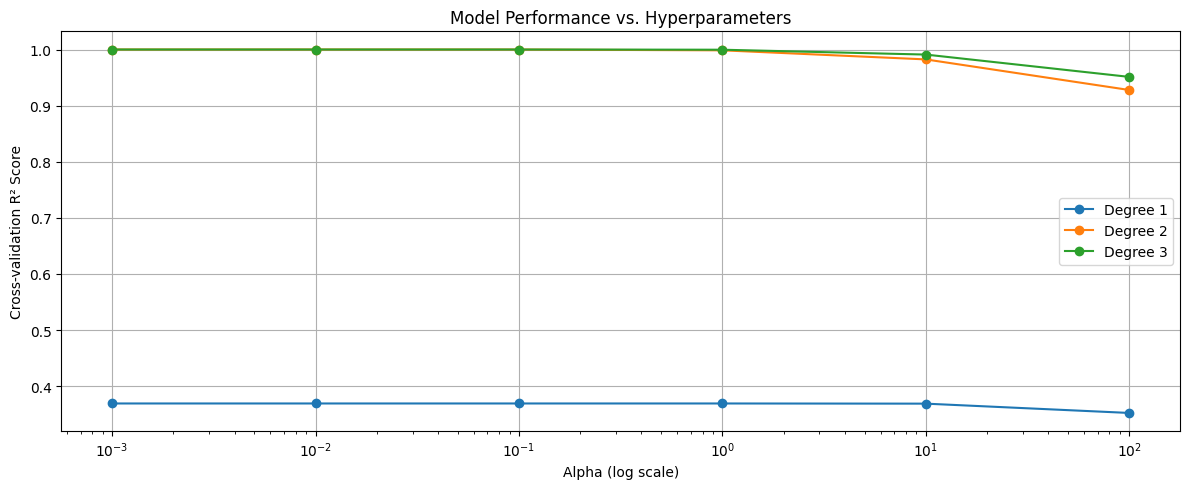


Final Model Performance:
R² Score: 1.0000
MSE: 0.0000

Top 10 Most Important Features in Best Model:


,Feature,Coefficient
53,How many times a week do you suffer headaches ...,0.483098
19,how would you rate your study load?_How would ...,-0.448194
17,How would you rate you academic performance 👩‍...,0.367246
93,how would you rate your study load? how would ...,0.340289
74,How would you rate you academic performance 👩‍...,0.320413
110,How many times a week you practice extracurric...,0.237047
453,How many times a week do you suffer headaches ...,-0.223699
76,How would you rate you academic performance 👩‍...,-0.217012
91,how would you rate your study load? How would ...,-0.217012
14,How many times a week do you suffer headaches ...,-0.211437


In [10]:
# Visualize the effects of hyperparameters
plt.figure(figsize=(12, 5))

# Plot effect of alpha for each polynomial degree
for degree in param_grid['poly__degree']:
    degree_results = cv_results[cv_results['params'].apply(lambda x: x['poly__degree'] == degree)]
    alphas = degree_results['params'].apply(lambda x: x['ridge__alpha'])
    scores = degree_results['mean_test_score']
    plt.plot(alphas, scores, marker='o', label=f'Degree {degree}')

plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Cross-validation R² Score')
plt.title('Model Performance vs. Hyperparameters')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Get the best model
best_model = grid_search.best_estimator_

# Make predictions with the best model
y_pred = best_model.predict(X)

# Calculate and print final metrics
final_r2 = r2_score(y, y_pred)
final_mse = mean_squared_error(y, y_pred)
print("\nFinal Model Performance:")
print(f"R² Score: {final_r2:.4f}")
print(f"MSE: {final_mse:.4f}")

# Create feature importance for the best model
if best_model.named_steps['poly'].degree > 1:
    feature_names = best_model.named_steps['poly'].get_feature_names_out(X.columns)
else:
    feature_names = X.columns

coefficients = best_model.named_steps['ridge'].coef_
importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})
importance = importance.sort_values('Coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features in Best Model:")
display(importance.head(10))

# Model Validation and Overfitting Analysis
Let's perform several checks:
1. Learning curves to assess overfitting
2. Residual analysis for model assumptions
3. Prediction error distribution
4. K-fold validation stability
5. Test set performance with different training sizes

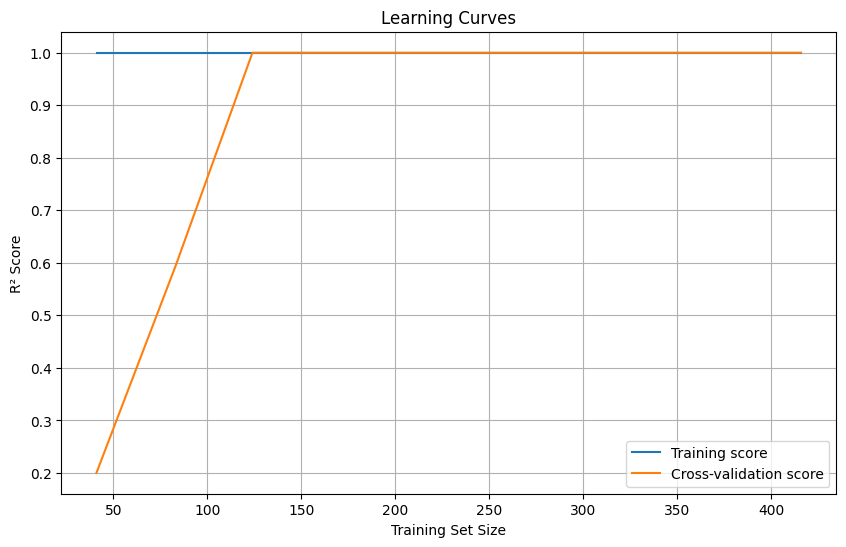

Model Performance Gap Analysis:
Final Training Score: 1.0000
Final Validation Score: 1.0000
Gap: 0.0000


In [11]:
# Import additional validation tools
from sklearn.model_selection import learning_curve
from sklearn.model_selection import KFold
import scipy.stats as stats

# Get the best model configuration
best_degree = grid_search.best_params_['poly__degree']
best_alpha = grid_search.best_params_['ridge__alpha']

# Create a fresh pipeline with the best parameters
best_pipeline = Pipeline([
    ('poly', PolynomialFeatures(degree=best_degree)),
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=best_alpha))
])

# Generate learning curves
train_sizes = np.linspace(0.1, 1.0, 10)
train_sizes, train_scores, val_scores = learning_curve(
    best_pipeline, X, y,
    train_sizes=train_sizes,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Cross-validation score')
plt.fill_between(train_sizes, np.mean(train_scores, axis=1) - np.std(train_scores, axis=1),
                 np.mean(train_scores, axis=1) + np.std(train_scores, axis=1), alpha=0.1)
plt.fill_between(train_sizes, np.mean(val_scores, axis=1) - np.std(val_scores, axis=1),
                 np.mean(val_scores, axis=1) + np.std(val_scores, axis=1), alpha=0.1)
plt.xlabel('Training Set Size')
plt.ylabel('R² Score')
plt.title('Learning Curves')
plt.legend(loc='best')
plt.grid(True)
plt.show()

# Print the gap between training and validation scores
print("Model Performance Gap Analysis:")
final_train_score = np.mean(train_scores[-1])
final_val_score = np.mean(val_scores[-1])
print(f"Final Training Score: {final_train_score:.4f}")
print(f"Final Validation Score: {final_val_score:.4f}")
print(f"Gap: {final_train_score - final_val_score:.4f}")

# Calculate prediction intervals
kf = KFold(n_splits=5, shuffle=True, random_state=42)
predictions = []
actuals = []

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_pipeline.fit(X_train, y_train)
    pred = best_pipeline.predict(X_val)
    predictions.extend(pred)
    actuals.extend(y_val)

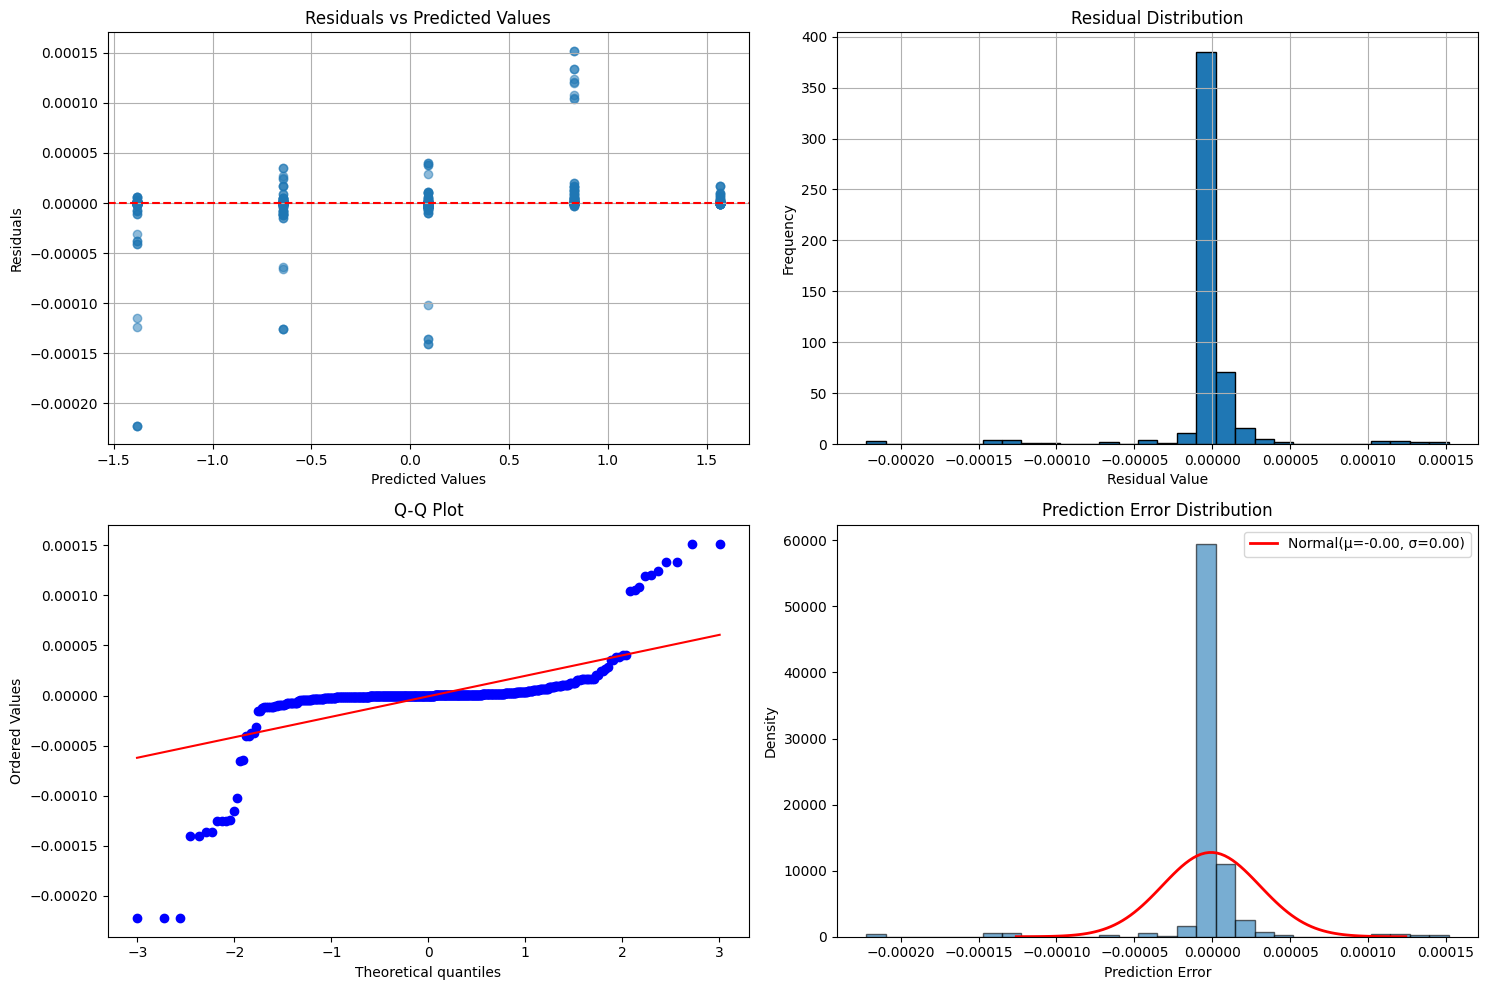


Model Assumptions Tests:
1. Shapiro-Wilk Test for Normality of Residuals:
   p-value: 0.0000 (Non-normal distribution)

Prediction Interval (95.0% confidence):
   ±0.00 units

Cross-validation Stability:
Mean R² Score: 1.0000
Standard Deviation: 0.0000
Coefficient of Variation: 0.0000

Cross-validation Stability:
Mean R² Score: 1.0000
Standard Deviation: 0.0000
Coefficient of Variation: 0.0000


In [13]:
# Plot residual analysis
predictions = np.array(predictions)
actuals = np.array(actuals)
residuals = actuals - predictions

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# 1. Residuals vs Predicted
ax1.scatter(predictions, residuals, alpha=0.5)
ax1.axhline(y=0, color='r', linestyle='--')
ax1.set_xlabel('Predicted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Predicted Values')
ax1.grid(True)

# 2. Residual Distribution
ax2.hist(residuals, bins=30, edgecolor='black')
ax2.set_xlabel('Residual Value')
ax2.set_ylabel('Frequency')
ax2.set_title('Residual Distribution')
ax2.grid(True)

# 3. Q-Q Plot
stats.probplot(residuals, dist="norm", plot=ax3)
ax3.set_title('Q-Q Plot')

# 4. Prediction Error Distribution
error_std = np.std(residuals)
error_mean = np.mean(residuals)
x = np.linspace(error_mean - 4*error_std, error_mean + 4*error_std, 100)
ax4.hist(residuals, bins=30, density=True, alpha=0.6, edgecolor='black')
ax4.plot(x, stats.norm.pdf(x, error_mean, error_std), 'r-', lw=2, 
         label=f'Normal(μ={error_mean:.2f}, σ={error_std:.2f})')
ax4.set_xlabel('Prediction Error')
ax4.set_ylabel('Density')
ax4.set_title('Prediction Error Distribution')
ax4.legend()

plt.tight_layout()
plt.show()

# Statistical tests for normality
print("\nModel Assumptions Tests:")
print("1. Shapiro-Wilk Test for Normality of Residuals:")
stat, p_value = stats.shapiro(residuals)
print(f"   p-value: {p_value:.4f} ({'Normal' if p_value > 0.05 else 'Non-normal'} distribution)")


# Calculate prediction intervals
confidence_level = 0.95
z_score = stats.norm.ppf((1 + confidence_level) / 2)
prediction_std = np.std(residuals)
margin_of_error = z_score * prediction_std

print(f"\nPrediction Interval ({confidence_level*100}% confidence):")
print(f"   ±{margin_of_error:.2f} units")

# Cross-validation stability
cv_scores = cross_val_score(best_pipeline, X, y, cv=10, scoring='r2')
print(f"\nCross-validation Stability:")
print(f"Mean R² Score: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")
print(f"Coefficient of Variation: {cv_scores.std()/cv_scores.mean():.4f}")